In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
data = pd.read_csv('../../../csv/Beras.csv')

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tanggal                   678 non-null    object
 1   Luas Panen Padi           678 non-null    int64 
 2   GKP Tingkat Petani        678 non-null    int64 
 3   GKP Tingkat Penggilingan  678 non-null    int64 
 4   GKG Tingkat Penggilingan  678 non-null    int64 
 5   Harga Beras Penggilingan  678 non-null    int64 
 6   Produksi Beras            678 non-null    int64 
 7   Harga Beras               678 non-null    int64 
 8   UMP                       678 non-null    int64 
 9   BBM Solar                 678 non-null    int64 
 10  Tingkat Konsumsi          678 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 58.4+ KB


(      Tanggal  Luas Panen Padi  GKP Tingkat Petani  GKP Tingkat Penggilingan  \
 0  2021-03-15               10                4000                      4150   
 1  2021-03-16               10                3850                      4100   
 2  2021-03-17               10                4160                      4230   
 3  2021-03-18               10                4120                      4190   
 4  2021-03-19               10                4190                      4290   
 
    GKG Tingkat Penggilingan  Harga Beras Penggilingan  Produksi Beras  \
 0                      5050                      9465           14419   
 1                      4740                      9360           14419   
 2                      4950                      9400           14419   
 3                      4730                      9340           14419   
 4                      4990                      9410           14419   
 
    Harga Beras   UMP  BBM Solar  Tingkat Konsumsi  
 0        112

In [3]:
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data['Year'] = data['Tanggal'].dt.year
data['Month'] = data['Tanggal'].dt.month

In [4]:
data_mod = data.drop(columns=['Tanggal'])

X = data_mod['Harga Beras']
y = data_mod['Harga Beras']

In [5]:
# Decompose the train and test data with a specified period of 7 days for weekly seasonality
decomposition_train = sm.tsa.seasonal_decompose(X, model='additive', period=12)
decomposition_test = sm.tsa.seasonal_decompose(y, model='additive', period=12)

# Collect the components for train data
train_trend = decomposition_train.trend.dropna()
train_seasonal = decomposition_train.seasonal.dropna()
train_residual = decomposition_train.resid.dropna()

# Collect the components for test data
test_trend = decomposition_test.trend.dropna()
test_seasonal = decomposition_test.seasonal.dropna()
test_residual = decomposition_test.resid.dropna()

# Display the components for train data
train_trend.head(), train_seasonal.head(), train_residual.head()

(6     11200.0
 7     11200.0
 8     11200.0
 9     11200.0
 10    11200.0
 Name: trend, dtype: float64,
 0   -3.534226
 1    5.859713
 2    3.435471
 3   -9.897863
 4   -6.867560
 Name: seasonal, dtype: float64,
 6      7.042073
 7     -1.291261
 8     -4.267451
 9    -17.065070
 10    -2.184118
 Name: resid, dtype: float64)

# Residual

In [6]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_residual = train_residual.iloc[:cutoff_index]
X_test_residual = train_residual.iloc[cutoff_index:]
y_train_residual = test_residual.iloc[:cutoff_index]
y_test_residual = test_residual.iloc[cutoff_index:]

In [7]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
xgb = XGBRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_residual = X_train_residual.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_residual, y_train_residual)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[11:01:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:01:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:01:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:01:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:01:42] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { 

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...),
 -52.12142995917719,
 {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50})

Mean Squared Error: 133.98122754890838


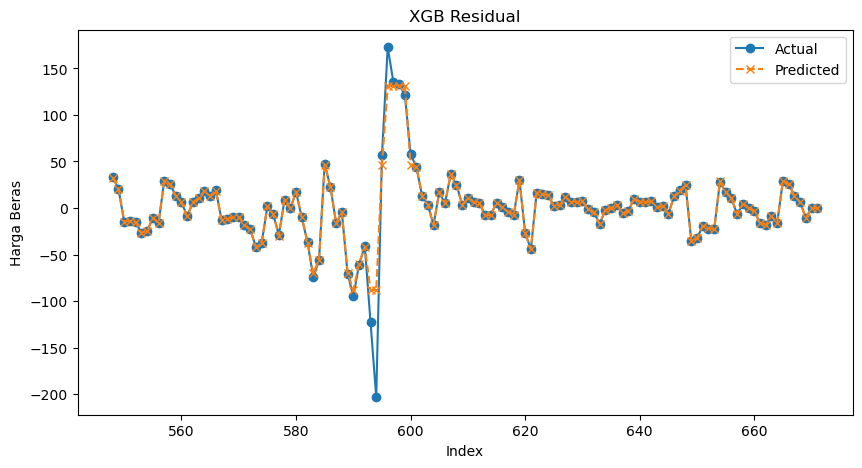

In [8]:
# Save the original index
original_index = X_test_residual.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_residual.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_residual = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_residual, predictions_residual)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_residual, label='Actual', marker='o')
plt.plot(original_index, predictions_residual, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('XGB Residual')
plt.legend()
plt.show()

# Seasonal

In [9]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_seasonal = train_seasonal.iloc[:cutoff_index]
X_test_seasonal = train_seasonal.iloc[cutoff_index:]
y_train_seasonal = test_seasonal.iloc[:cutoff_index]
y_test_seasonal = test_seasonal.iloc[cutoff_index:]

In [10]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
xgb = XGBRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_seasonal = X_train_seasonal.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_seasonal, y_train_seasonal)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[11:02:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:00] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { 

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...),
 -4.071578686986698e-09,
 {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50})

Mean Squared Error: 3.084217737180663e-09


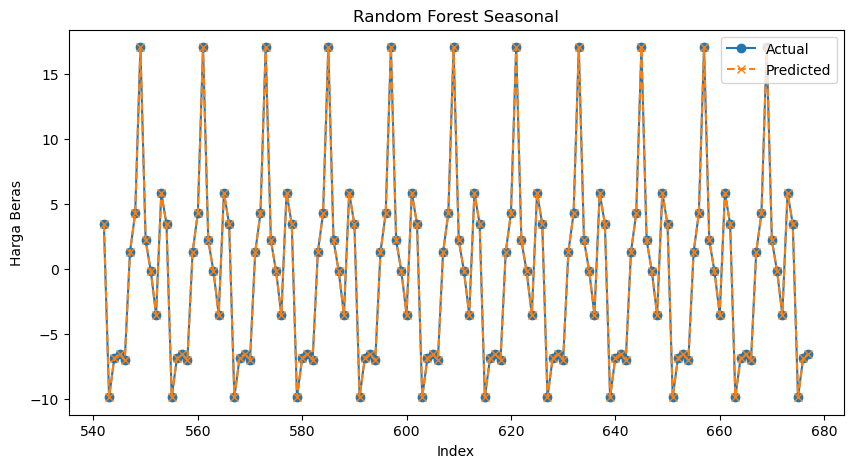

In [11]:
# Save the original index
original_index = X_test_seasonal.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_seasonal.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_seasonal = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_seasonal, predictions_seasonal)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_seasonal, label='Actual', marker='o')
plt.plot(original_index, predictions_seasonal, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('Random Forest Seasonal')
plt.legend()
plt.show()

# Trend

In [12]:
cutoff_index = int(len(data_mod) * 0.8)

# Split the dataset into training and testing sets using the calculated index
X_train_trend = train_trend.iloc[:cutoff_index]
X_test_trend = train_trend.iloc[cutoff_index:]
y_train_trend = test_trend.iloc[:cutoff_index]
y_test_trend = test_trend.iloc[cutoff_index:]

In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 10, 20]  # Minimum number of samples required to split an internal node
}

# Initialize the RandomForestRegressor
xgb = XGBRegressor(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Reshape X_train to a 2D array
X_train_trend = X_train_trend.values.reshape(-1, 1)

# Fit GridSearchCV
grid_search.fit(X_train_trend, y_train_trend)

# Evaluate the best model from grid search
best_rf = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

best_rf, best_score, best_params

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[11:02:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_split" } are not used.

[11:02:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { 

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, min_samples_split=2, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...),
 -31457.171185586845,
 {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100})

Mean Squared Error: 1254331.9077936627


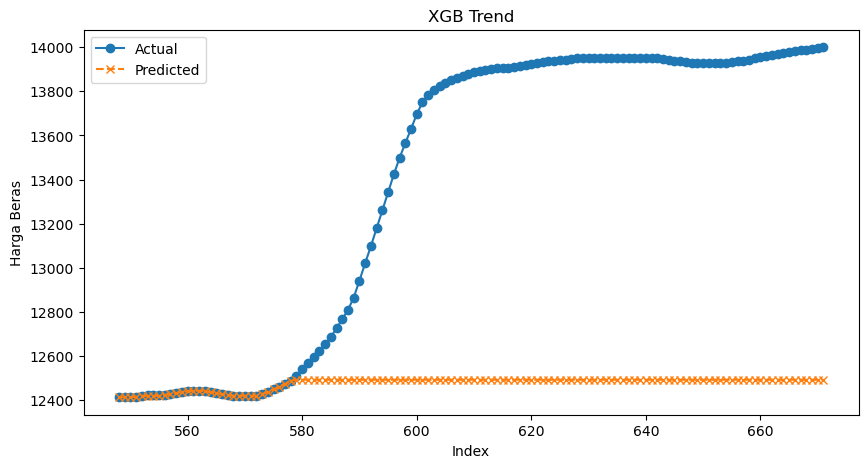

In [14]:
# Save the original index
original_index = X_test_trend.index

# Convert X_test to a numpy array and reshape it to a 2D array
X_testreshape = X_test_trend.values.reshape(-1, 1)

# Make predictions on the testing data using the best Random Forest model
predictions_trend = best_rf.predict(X_testreshape)

# Evaluate the model
mse = mean_squared_error(y_test_trend, predictions_trend)

print('Mean Squared Error:', mse)

# Optionally, visualize the actual and predicted values
plt.figure(figsize=(10, 5))
# Use the original index in the plot
plt.plot(original_index, y_test_trend, label='Actual', marker='o')
plt.plot(original_index, predictions_trend, label='Predicted', linestyle='--', marker='x')
plt.xlabel('Index')
plt.ylabel('Harga Beras')
plt.title('XGB Trend')
plt.legend()
plt.show()

In [15]:
# Ensure all arrays have the same length
min_length = min(len(predictions_residual), len(predictions_seasonal), len(predictions_trend))

# Trim the arrays to the minimum length
predictions_residual = predictions_residual[:min_length]
predictions_seasonal = predictions_seasonal[:min_length]
predictions_trend = predictions_trend[:min_length]

# Now you can add them together
predict_result = predictions_residual + predictions_seasonal + predictions_trend
predict_result

array([12448.666 , 12423.171 , 12391.034 , 12393.795 , 12396.578 ,
       12393.464 , 12398.272 , 12424.911 , 12409.046 , 12456.371 ,
       12453.473 , 12454.559 , 12449.223 , 12422.87  , 12441.003 ,
       12443.554 , 12446.732 , 12445.481 , 12450.022 , 12427.195 ,
       12409.143 , 12408.502 , 12405.577 , 12406.585 , 12399.155 ,
       12375.084 , 12391.368 , 12443.619 , 12447.025 , 12444.649 ,
       12500.824 , 12508.21  , 12511.274 , 12481.418 , 12450.946 ,
       12427.491 , 12438.751 , 12528.22  , 12507.787 , 12468.843 ,
       12479.818 , 12422.923 , 12407.835 , 12448.507 , 12452.387 ,
       12403.371 , 12400.033 , 12543.978 , 12626.729 , 12613.3955,
       12616.426 , 12616.729 , 12531.075 , 12537.4375, 12509.212 ,
       12512.266 , 12475.826 , 12508.446 , 12493.026 , 12533.816 ,
       12519.712 , 12485.303 , 12495.134 , 12491.533 , 12490.441 ,
       12485.035 , 12488.335 , 12514.549 , 12494.464 , 12487.695 ,
       12480.582 , 12527.473 , 12467.793 , 12437.542 , 12501.3

In [16]:
y_test_result = y_test_residual + y_test_seasonal + y_test_trend
y_test_result

542   NaN
543   NaN
544   NaN
545   NaN
546   NaN
       ..
673   NaN
674   NaN
675   NaN
676   NaN
677   NaN
Length: 136, dtype: float64

In [17]:
import numpy as np

# Remove NaN values from the arrays
predict_result = predict_result[~np.isnan(predict_result)]
y_test_result = y_test_result[~np.isnan(y_test_result)]

# Ensure both arrays have the same length
min_length = min(len(predict_result), len(y_test_result))

# Trim the arrays to the minimum length
predict_result = predict_result[:min_length]
y_test_result = y_test_result[:min_length]

# Now you can calculate the errors
rmse = sqrt(mean_squared_error(predict_result, y_test_result))
mae = mean_absolute_error(predict_result, y_test_result)
mse = mean_squared_error(predict_result, y_test_result)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Square Error:", mse)

Root Mean Square Error: 1119.8262239818305
Mean Absolute Error: 913.917732484879
Mean Square Error: 1254010.7719174046
